In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , BatchNormalization , Lambda , Activation , Dropout
from keras import backend as K

import matplotlib.pyplot as plt

In [2]:
TARGET_X = 256
TARGET_Y = 256
BATCH_SIZE = 32
CLASS_NUM = 1103
EPOCH = 15


In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('./multilabel_small.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].apply(lambda x:x.split(" "))
train_classes["id"]=train_classes["id"].apply(lambda x:x+".png")

print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1007057734dba6df.png         [189]
1   1009f5737fc77f2.png         [188]
2  100a58282c6584bf.png         [147]
3  100b45b7c4020f5d.png         [161]
4  101695e8cefdc9c4.png          [13]


In [4]:
labels = list(map(str, range(CLASS_NUM)))

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2,
                             horizontal_flip = True,    
                             zoom_range = 0.3,
                             width_shift_range = 0.3,
                             height_shift_range=0.3)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             classes=labels,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             classes=labels,
                                             class_name='categorical')

Found 9546 validated image filenames belonging to 1103 classes.
Found 2386 validated image filenames belonging to 1103 classes.


In [13]:
model = Sequential()

model.add(Conv2D(96, 7, strides=3, padding='same', input_shape=(TARGET_X,TARGET_Y,3)))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(256, 5, strides=3, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Dropout(0.5))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 86, 86, 96)        14208     
_________________________________________________________________
lambda_4 (Lambda)            (None, 86, 86, 96)        0         
_________________________________________________________________
activation_10 (Activation)   (None, 86, 86, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 256)       614656    
_________________________________________________________________
lambda_5 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
activation_11 (Activation)   (None, 14, 14, 256)      

In [7]:
#loss function

gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

#f2 metric

def f2_score(y_true, y_pred):
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))

In [14]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall", f2_score])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCH,
                    verbose=1)

Epoch 1/15
298/298 [==============================] - 202s 671ms/step - loss: 4.0921 - accuracy: 0.1280 - precision: 0.1003 - recall: 0.0029 - f2_score: 0.0027 - val_loss: 5.6293 - val_accuracy: 0.1660 - val_precision: 0.1671 - val_recall: 0.1609 - val_f2_score: 0.1623
Epoch 2/15
298/298 [==============================] - 206s 691ms/step - loss: 15.8061 - accuracy: 0.0975 - precision: 0.0917 - recall: 0.0503 - f2_score: 0.0507 - val_loss: 24.2515 - val_accuracy: 0.1660 - val_precision: 0.1664 - val_recall: 0.1609 - val_f2_score: 0.1623
Epoch 3/15
298/298 [==============================] - 212s 710ms/step - loss: 210.9896 - accuracy: 0.0823 - precision: 0.0843 - recall: 0.0802 - f2_score: 0.0820 - val_loss: 382.5548 - val_accuracy: 0.1660 - val_precision: 0.1664 - val_recall: 0.1609 - val_f2_score: 0.1623
Epoch 4/15
298/298 [==============================] - 219s 736ms/step - loss: 6979.4626 - accuracy: 0.0736 - precision: 0.0746 - recall: 0.0719 - f2_score: 0.0731 - val_loss: 68002.703

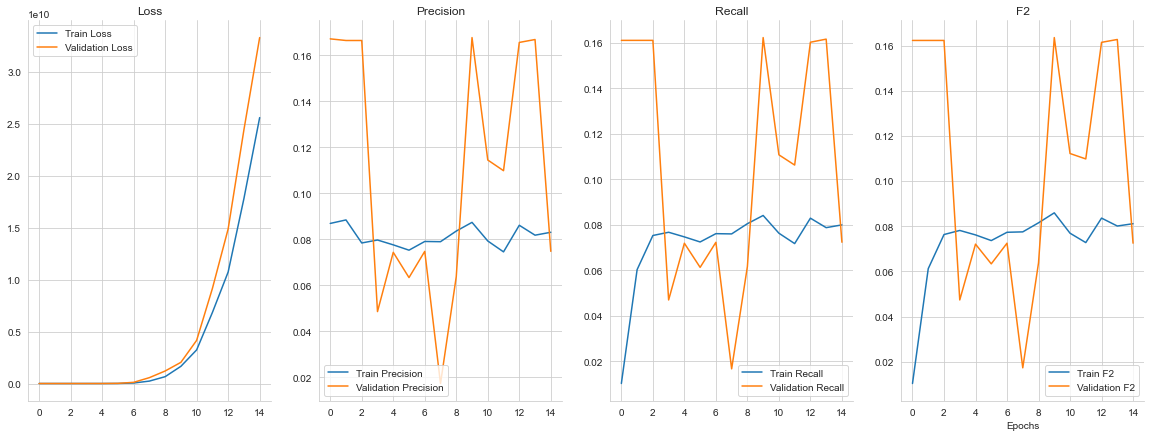

In [15]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['precision'], label='Train Precision')
ax2.plot(history.history['val_precision'], label='Validation Precision')
ax2.legend(loc='best')
ax2.set_title('Precision')

ax3.plot(history.history['recall'], label='Train Recall')
ax3.plot(history.history['val_recall'], label='Validation Recall')
ax3.legend(loc='best')
ax3.set_title('Recall')

ax4.plot(history.history['f2_score'], label='Train F2')
ax4.plot(history.history['val_f2_score'], label='Validation F2')
ax4.legend(loc='best')
ax4.set_title('F2')

plt.xlabel('Epochs')
sns.despine()
plt.show()